In [1]:
# Dependencias
import os
import math
import tempfile
import tensorflow as tf 
import numpy as np 
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt 
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import datasets, utils, preprocessing
from tensorflow.keras import models, losses, optimizers, regularizers
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow .keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from numpy.random import seed
from tensorflow import random

In [2]:
# Comprobar versión de TensorFlow
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# Fijar semilla
seed(22)
random.set_seed(22)

2.3.0
Num GPUs Available:  0


In [3]:
# Definición de tamaño de la imagen y nº de canales
img_rows, img_cols = 160, 160
num_dim = 3
num_classes = 10

In [4]:
# Crear un nuevo generador
train_imagegen = ImageDataGenerator(
        rescale=1./255,    
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)

test_imagegen = ImageDataGenerator(rescale=1./255)
# Cargar datos de entrenamiento
train = train_imagegen.flow_from_directory("../../datasets/imagenette2-160/train/",
                                     class_mode="categorical", 
                                     shuffle=True,
                                     batch_size=32, 
                                     target_size=(160, 160))
#  Cargar datos de validación
val = test_imagegen.flow_from_directory("../../datasets/imagenette2-160/val/", 
                                   class_mode="categorical"
                                        
                                        , 
                                   shuffle=True, 
                                   batch_size=32, 
                                   target_size=(160, 160))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [5]:
# Reimplementación en Keras de VGG16
# Basada en https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

imagenettenet = Sequential()
imagenettenet.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (160, 160, 3)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(Conv2D(32, (3, 3)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(MaxPooling2D(pool_size=(2, 2)))
imagenettenet.add(Dropout(0.25))

imagenettenet.add(Conv2D(64, (3, 3), padding='same'))
imagenettenet.add(Activation('relu'))
imagenettenet.add(Conv2D(64, (3, 3)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(MaxPooling2D(pool_size=(2, 2)))
imagenettenet.add(Dropout(0.25))

imagenettenet.add(Conv2D(128, (3, 3), padding='same'))
imagenettenet.add(Activation('relu'))
imagenettenet.add(Conv2D(128, (3, 3)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(MaxPooling2D(pool_size=(2, 2)))
imagenettenet.add(Dropout(0.25))

imagenettenet.add(Conv2D(256, (3, 3), padding='same'))
imagenettenet.add(Activation('relu'))
imagenettenet.add(Conv2D(256, (3, 3)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(MaxPooling2D(pool_size=(2, 2)))
imagenettenet.add(Dropout(0.25))

imagenettenet.add(Flatten())
imagenettenet.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
imagenettenet.add(Activation('relu'))
imagenettenet.add(Dropout(0.1))
#imagenettenet.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
#imagenettenet.add(Activation('relu'))
#imagenettenet.add(Dropout(0.5))
imagenettenet.add(Dense(num_classes))
imagenettenet.add(Activation('softmax'))

imagenettenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 158, 158, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 64)        1

In [6]:
# Definición de hiperparámetros
learning_rate = 0.0001 # learning rate
lr_decay = 1e-6
lr_drop = 20
epochs = 20  # Número de epochs

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

sgd = keras.optimizers.SGD(lr=0.001, decay=lr_decay, momentum=0.9, nesterov=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=0)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                     min_delta=0, 
                                                     patience=8, 
                                                     verbose=0, 
                                                     mode='auto', 
                                                     baseline=None, 
                                                     restore_best_weights=False)

# Compilamos la red neuronal
imagenettenet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Entrenamos el modelo
model_path = 'imagenetteNetKeras.h5'
model_checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True)

history = imagenettenet.fit_generator(
          train,
          epochs=epochs,
          validation_data=val,
          verbose = 1,
          callbacks=[model_checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
296/296 [==============================] - ETA: 0s - loss: 4.1816 - accuracy: 0.2381
Epoch 00001: loss improved from inf to 4.18159, saving model to imagenetteNetKeras.h5
296/296 [==============================] - 377s 1s/step - loss: 4.1816 - accuracy: 0.2381 - val_loss: 2.3193 - val_accuracy: 0.3549
Epoch 2/20
296/296 [==============================] - ETA: 0s - loss: 2.0922 - accuracy: 0.3605
Epoch 00002: loss improved from 4.18159 to 2.09219, saving model to imagenetteNetKeras.h5
296/296 [==============================] - 376s 1s/step - loss: 2.0922 - accuracy: 0.3605 - val_loss: 2.1027 - val_accuracy: 0.3373
Epoch 3/20
296/296 [==============================] - ETA: 0s - loss: 1.8531 - accuracy: 0.4191
Epoch 00003: loss improved from 2.09219 to 1.85313, saving model to imagenetteNetKeras.h5
296/296 [==============================] - 380s 1s/step - loss: 1.8531 - accuracy: 0.4191 - val_loss: 1.76

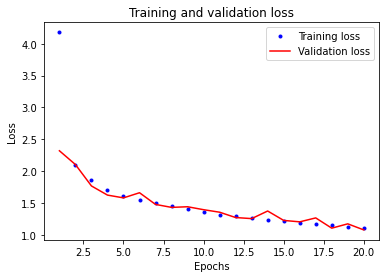

In [8]:
# Pintar gráfica de Loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
# Guardar a disco modelo de Keras en formato h5 y h5py
imagenettenet.save('imagenetteNetKeras.h5')